# STROJNO UČENJE - PROJEKT
## EDA Student Performance Dataset
### Predviđanje uspjeha učenika pomoću demografskih i socio-ekonomskih informacija

# Sadržaj
[Library Import](#Library-import)

[Vizualizacija podataka](#Vizualizacija-podataka)

- [Kategoričke varijable](#Kategoričke-značajke)

- [Numeričke varijable](#Numeričke-značajke)

- [Usporedba spola](#Usporedba-spola)


[Feature Selection](#Feature-selection-&-encoding)

[Modeli](#Modeli)
- [Priprema podataka](#Priprema-podataka)

    -[Label Encoding](#Label-encoding)
    
    -[Train-test Split](#Train-Test-Split)

- [Regresija](#Modeli-linearne-regresije)

    -[Linearna Regresija](#Linearna-regresija)
    
    -[Lasso](#MultitaskLasso-Regresija-(3-izlaza))
    
    -[Ridge](#Ridge-regresija)
   
- [Slučajne šume](#slučajne-šume)

# Library import

In [1]:
#%% Imports


#SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection 

import squarify
from sklearn.pipeline import Pipeline


# Basic Imports 
import numpy as np
import pandas as pd

# Plotting 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Metrics 
import sklearn.metrics
from sklearn.metrics import *

# ML Models
import lightgbm as lgb
from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge
# Model Tuning 
from bayes_opt import BayesianOptimization

# Feature Importance 
import shap

# Ignore Warnings 
import warnings
warnings.filterwarnings('ignore')



# Import dataseta

In [2]:
df = pd.read_csv('StudentsPerformance.csv')

df['AVERAGE'] = df[['math score', 'reading score','writing score']].mean(axis=1)

# Vizualizacija podataka

In [3]:

df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,AVERAGE
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


Skup podataka sastoji se od 8 stupaca i 1000 redaka, odnosno podataka o studentima:

In [4]:
df.shape

(1000, 9)

## Kategoričke značajke

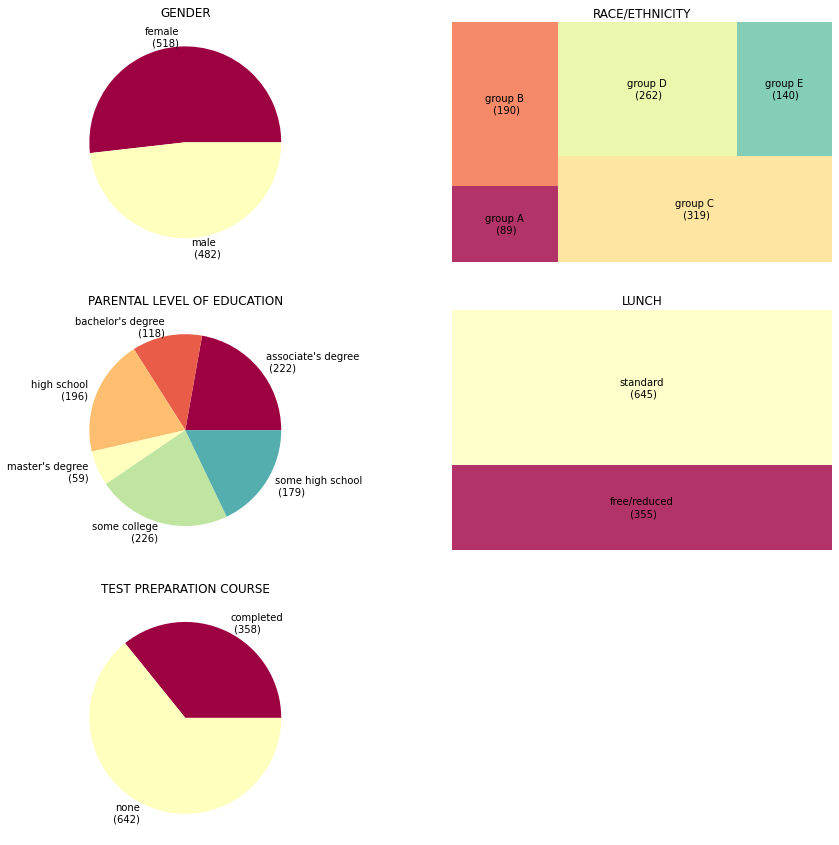

In [5]:
f, axes=plt.subplots(3, 2, figsize=(15, 15))
for i in range(5):
    plt.subplot(3, 2, i+1)
    
    df_grouped= df.groupby(df.columns[i]).size().reset_index(name='counts')
    labels = df_grouped.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = df_grouped['counts'].values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
    
    if i % 2 == 1:
       squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)
    else:
        plt.pie(sizes, labels=labels, colors=colors)
    plt.title(df.columns[i].upper())
    plt.axis('off')
    
plt.subplot(3, 2, 6)
plt.axis('off')
plt.show()

## Swarmplot kategoričkih atributa po oznaci,tj. broju bodova

<AxesSubplot:xlabel='parental level of education', ylabel='AVERAGE'>

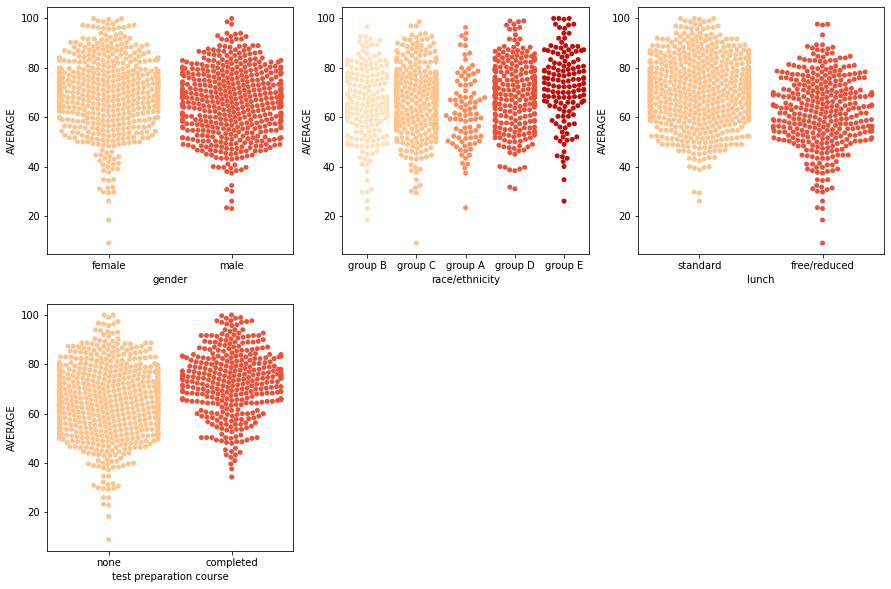

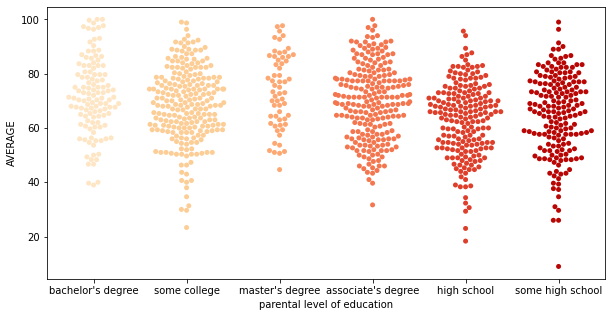

In [6]:
table=df.copy()
table = table.drop(["math score","reading score","writing score","AVERAGE","parental level of education"],axis = 'columns') 

plt.figure(figsize=(15,10))
for indx,val in enumerate(table.columns):
    plt.subplot(2,3,indx+1)
    sns.swarmplot(x=df[val],y=df['AVERAGE'],palette='OrRd')

plt.figure(figsize=(10,5))
sns.swarmplot(x=df['parental level of education'],y=df['AVERAGE'],palette='OrRd')
    

## Numeričke značajke

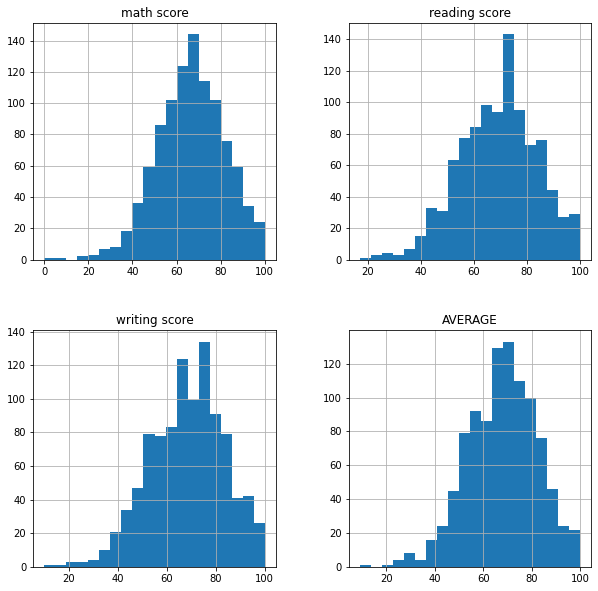

In [7]:
df.hist(figsize=(10,10),bins = 20)
plt.show()

# Feature selection & encoding

## Kodiranje atributa

Moramo napraviti preinake u našim podacima. Točnije, smetaju nam kategoričke varijable pošto algoritmi strojnog učenja ne rade sa kategoričkim varijablama. Postoji više pristupa tom problemu: 

    - One Hot Encoding (funkcija get_dummies)
    - Biblioteka LabelEncoder
    - Ručno, pomoću funkcije replace
    
Referenca: https://pbpython.com/categorical-encoding.html

In [8]:
# moramo napraviti label encoding
# pogledajmo prvo koje su nam vrijednosti u svakom stupcu
for col in df:
    if col == 'math score':
        break
    print(col, ' --> ', df[col].unique())

gender  -->  ['female' 'male']
race/ethnicity  -->  ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education  -->  ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch  -->  ['standard' 'free/reduced']
test preparation course  -->  ['none' 'completed']


In [9]:
def find_and_replace(data):
    cleanup_nums = {
        'gender': { "female": 0, 'male': 1 },
        'race/ethnicity': { 'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4 },
        'parental level of education': { 'some high school': 0, 'high school': 1,
                                        "associate's degree": 2, 'some college': 3,
                                        "bachelor's degree": 4, "master's degree": 5,  },
        'lunch': { 'standard': 0, 'free/reduced': 1 },
        'test preparation course': { 'none': 0, 'completed': 1 },
    }
    return df.replace(cleanup_nums)

#one hot encoding
def one_hot_encoding(data):
    # we rename first and last columns for scalability, so we dont have to change our code in multiple places
    return pd.get_dummies(data, columns=['gender', 'race/ethnicity', \
                                       'parental level of education', \
                                       'lunch', 'test preparation course'], \
                          drop_first=True) \
            .rename(columns={\
                             'gender_male' : 'gender',\
                             'test preparation course_none' : 'test preparation course'\
                            })




def encode_data(table_input,enc_type="ONEHOT",removeY=True):
    
    table= table_input.copy()
    #target= table["AVERAGE"]
    if removeY:
        table = table.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
    
    
    if enc_type == "ONEHOT":
        table = table.apply(lambda x: x.astype('category')) 
        table = pd.get_dummies(table,drop_first= True)
        return table
        #return one_hot_encoding(table)
        
    elif enc_type == "LABEL":
        categorical_features = table.select_dtypes(['object','category']).columns.to_list()
        labelencoder = LabelEncoder()
        for i in categorical_features:
            table[i] = labelencoder.fit_transform(table[i])
            
        return table
    else:
        return find_and_replace(table)
    
#Kako koristiti:

#X_features_encoded = encode_data(SP_csv_clean,enc_type="ONE HOT")
#X_features_encoded

#X_features_encoded = encode_data(SP_csv_clean,enc_type="LABEL")
#X_features_encoded

## Feature selection

In [10]:
def odaberi(algorithm,k,X_train, y_train,yname="not given"):
    selector = feature_selection.SelectKBest(algorithm, k)
    selector.fit(X_train, y_train)
    scores = -np.log10(selector.pvalues_)
    indices = np.argsort(scores)[::-1] # Vrati indekse koji sortiraju polje (obratno)

    plt.figure(figsize=(7,5))
    plt.plot(range(X_train.shape[1]), scores[indices], 'o', color='gray')
    plt.title(f'Univarijantni odabir znacajki za najvaznijih {k_best} znacajki')
    plt.ylabel(f'log p-vrijednosti metode {yname}')
    plt.xlim([-1, X_train.shape[1]])
    plt.xticks(range(X_train.shape[1]), X_train.columns.values[indices], rotation=90)
    plt.vlines(k_best-0.5, 0, np.max(scores), color='red', linestyle='--')
    plt.grid(True,linestyle='--')
    plt.tight_layout()

    [ i.set_color("red") for i in plt.gca().get_xticklabels() if i.get_text()[:5] == 'noise' ]

    plt.show()

### 1.Odabir encodinga za feature selection : ONE HOT ENCODING

In [11]:
X_features_encoded = encode_data(df,enc_type="ONEHOT")
Y = df["AVERAGE"]
k_best = int(len(X_features_encoded.columns)*0.8) 

In [12]:
X_train_N, X_test_N, y_train_N, y_test_N = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    random_state=1
)

y_train_N=y_train_N.astype('int')


### Rezultat s metodom: f_regression

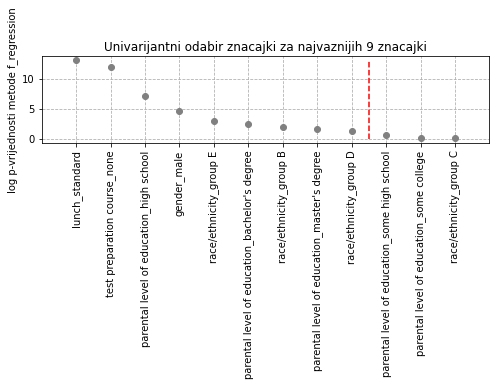

In [13]:
odaberi(feature_selection.f_regression,k_best,X_train_N, y_train_N,yname="f_regression")

### Rezultat s metodom: chi2

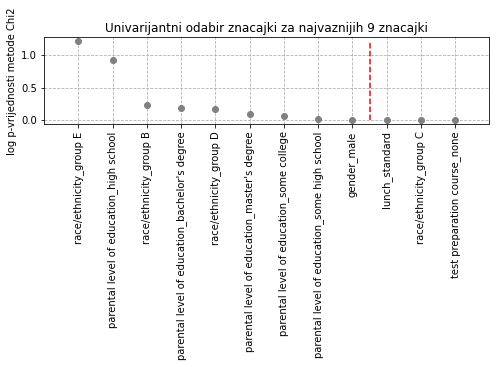

In [14]:
odaberi(feature_selection.chi2,k_best,X_train_N, y_train_N,yname="Chi2")

### 2.Odabir encodinga za feature selection : LABEL


In [15]:
X_features_encoded = encode_data(df,enc_type="LABEL")
Y = df["AVERAGE"]

k_best = int(len(X_features_encoded.columns)*0.8) 

In [16]:
X_train_N, X_test_N, y_train_N, y_test_N = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    random_state=1
)

y_train_N=y_train_N.astype('int')

### Rezultat s metodom: f_regression

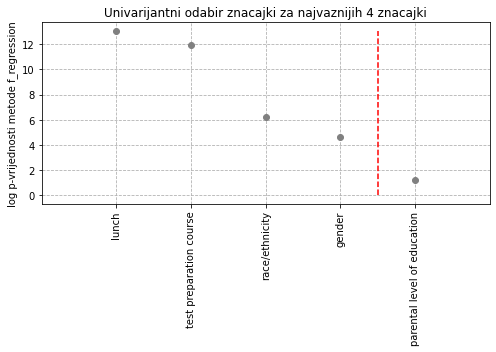

In [17]:
odaberi(feature_selection.f_regression,k_best,X_train_N, y_train_N,yname="f_regression")

### Rezultat s metodom: chi2

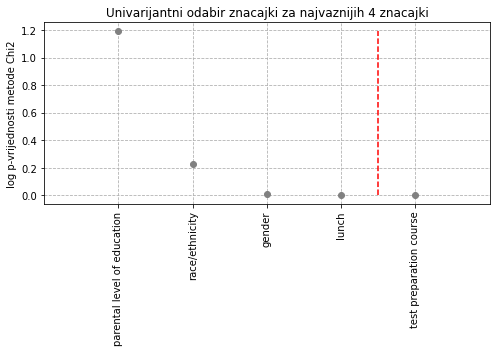

In [18]:
odaberi(feature_selection.chi2,k_best,X_train_N, y_train_N,yname="Chi2")

# Modeli

Na raspolaganju imamo puno različitih algoritama strojnog učenja koje možemo primjeniti na ovaj problem. Ideja je da prvo krenemo od jednostavnijih, pa nadograđujemo prema onim kompleksnijim modelima. 
Za početak ćemo iskoristiti sljedeće algoritme:
        
        - Algoritmi regresije
        - Support vector machines (SVM)
        - Slučajne šume

## Priprema podataka

### Funkcije za ispis grešaka

In [19]:
def residual(true,pred):
    resid = true - pred
    print( np.sqrt(np.mean(resid*resid)) )
def evaluateRegressor(true,predicted,message = "Test set evaluation:"):
    MSE = mean_squared_error(true,predicted,squared = True)
    MAE = mean_absolute_error(true,predicted)
    RMSE = mean_squared_error(true,predicted,squared = False)
    R_squared = r2_score(true,predicted)
    print(message)
    print("MSE:", MSE)
    print("MAE:", MAE)
    print("RMSE:", RMSE)
    print(f"R-squared: {R_squared} , from <0,1> ")
    return [MSE,MAE,RMSE,R_squared]

### Train Test Split
Pošto nemamo unaprijed zadane trening i test podatke, uobičajeno je podijeliti cijelu našu bazu u dio za trening i dio za test. Najčešće se koristi sklearn funkcija train_test_split koja prima postotak podataka koji želimo da bude testni. U našem slučaju stavit ćemo 20% (800 trening, 200 test podataka).

In [20]:
X_features_encoded = encode_data(df,enc_type="LABEL")
Y = df["AVERAGE"]

Y_class= pd.cut(Y,
       5, labels=[1,2,3,4,5])

X_train, X_test, y_train, y_test = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)

#y_train_N=y_train_N.astype('int')

In [21]:
df_temp = df.copy()
df_temp['Total score'] = ((df['math score']+df['writing score']+df['reading score'])/3).round(2)
df_temp=df_temp.drop(["AVERAGE"],axis = 'columns')

In [22]:
df2 = one_hot_encoding(df_temp)
train, test = train_test_split(df2, test_size=0.2)
features = train.loc[:, 'gender' : 'test preparation course']
targets = train.loc[:, 'math score' : 'Total score']

Ako ce nam trebat skalirani podaci ,tu su

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Evaluacije spremamo u tablicu

In [24]:
data=[]
data=pd.DataFrame(data, columns=["MSE", "MAE","RMSE", "R^2"])
data.index.astype(str, copy = False)

data

,MSE,MAE,RMSE,R^2


## Modeli linearne regresije

Osnovni algoritam regresije (a i cijele teorije strojnog učenja) je linearna regresija. Osim nje, postoje i neke modifikacije. Svaka ima svoje prednosti i mane, zbog kojih se sve koriste u određenim situacijama. Mi ćemo iskoristiti Lasso i Ridge, te usporediti rezultate svih.

### Linearna Regresija

In [25]:
model = Pipeline([ ('linear', LinearRegression()) ])
model = model.fit(features, targets)

regr_pred = model.predict(test.loc[:, 'gender' : 'test preparation course'])
#print(regr_pred)

correct_scores = test.loc[:, 'math score' : 'Total score']
explained_variance = explained_variance_score(correct_scores, regr_pred)
R2 = r2_score(correct_scores, regr_pred)
MSE = mean_squared_error(correct_scores, regr_pred)

print('Objasnjena varijanca = '+'{0:.2f}'.format(explained_variance)+'\nR2 = '+'{0:.2f}'.format(R2)+'\nMSE = '+'{0:.2f}'.format(MSE))

Objasnjena varijanca = 0.19
R2 = 0.17
MSE = 193.34


In [26]:
def lin_reg(X,y):
    LinearReg = LinearRegression(normalize = True)
    LinearReg = LinearReg.fit(X,y)

    return LinearReg


In [27]:
model_LINEAR = lin_reg(X_train,y_train)

predicted_y_test = model_LINEAR.predict(X_test)

In [28]:
residual(y_test, predicted_y_test)

data.loc['linearna'] = evaluateRegressor(y_test, predicted_y_test)


12.481086111729132
Test set evaluation:
MSE: 155.77751052839784
MAE: 10.093111269576807
RMSE: 12.481086111729132
R-squared: 0.20887568811254076 , from <0,1> 


### MultitaskLasso Regresija (3 izlaza)

In [29]:
X_lasso =df.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
Y_3_lasso =df[["math score","reading score","writing score"]]

X_lasso = encode_data(X_lasso,enc_type="LABEL",removeY=False)

In [30]:
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(
    X_lasso, 
    Y_3_lasso, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)

In [31]:
# import linear model library
from sklearn import linear_model
  
# create MultiTaskLasso model
MTL = linear_model.MultiTaskLasso(alpha = 0.5)

# fit the model to a data
#MTL.fit([[1, 0], [1, 3], [2, 2]], [[0, 2], [1, 4], [2, 4]])
MTL.fit(X_train_lasso,y_train_lasso)

pred=MTL.predict(X_test_lasso)
# perform prediction and print the result
#print("Prediciton result: \n", MTL.predict(X_test_lasso), "\n")
  
# print the coefficients
#print("Coefficients: \n", MTL.coef_, "\n")
  
# print the intercepts
#print("Intercepts: \n", MTL.intercept_, "\n")
  
# print the number of iterations performed
#print("Number of Iterations: ", MTL.n_iter_, "\n")

In [32]:
#residual(y_test_lasso, pred)

print("\nScores:")

data.loc['Multi-Lasso'] = evaluateRegressor(y_test_lasso, pred)


Scores:
Test set evaluation:
MSE: 199.82978609088596
MAE: 11.198105459422871
RMSE: 14.13114880844063
R-squared: 0.18738038924168535 , from <0,1> 


## Ridge regresija

Objasnjena varijanca = 0.19
R2 = 0.18
MSE = 191.29


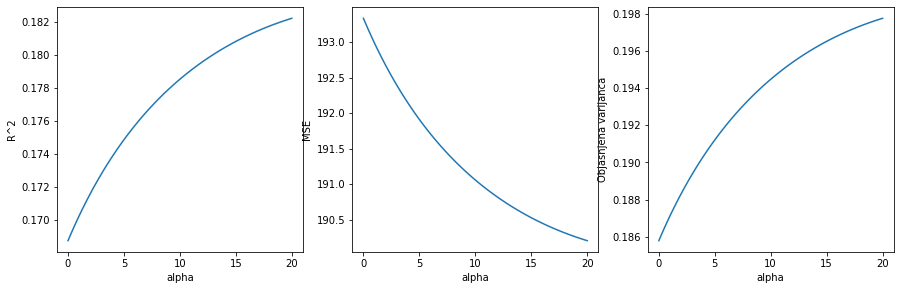

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))
alpha_array = np.linspace(0.01, 20.0, 100)
R2 = []
MSE = []
explained_variance = []

for alpha in alpha_array:
    model_ridge = Pipeline( [ ('ridge', Ridge(alpha=alpha)) ] )
    model_ridge = model_ridge.fit(features, targets)
    #R2_ridge = model_ridge.score(test.loc[:, 'gender' : 'test preparation course'], correct_scores)
    regr_pred = model_ridge.predict(test.loc[:, 'gender' : 'test preparation course'])
    
    
    explained_variance.append(explained_variance_score(correct_scores, regr_pred))
    R2.append(r2_score(correct_scores, regr_pred))
    MSE.append(mean_squared_error(correct_scores, regr_pred))

def avg(arr):
    return sum(arr) / len(arr)

print('Objasnjena varijanca = '+'{0:.2f}'.format(avg(explained_variance))+'\nR2 = '+'{0:.2f}'.format(avg(R2))+'\nMSE = '+'{0:.2f}'.format(avg(MSE)))


ax[0].plot(alpha_array, R2)
ax[0].set(xlabel='alpha', ylabel='R^2')
ax[1].plot(alpha_array, MSE)
ax[1].set(xlabel='alpha', ylabel='MSE')
ax[2].plot(alpha_array, explained_variance)
ax[2].set(xlabel='alpha', ylabel='Objasnjena varijanca')

plt.show()

## LightGBM

In [34]:
LGBMReg = lgb.LGBMRegressor(random_state=0).fit(X_train,y_train)

predicted_y_train = LGBMReg.predict(X_train)
evaluateRegressor(y_train,predicted_y_train,"    Training Set")
predicted_y_test = LGBMReg.predict(X_test)


data.loc['LightGBM'] = evaluateRegressor(y_test,predicted_y_test)


    Training Set
MSE: 135.13927747098754
MAE: 9.253269289079478
RMSE: 11.624942041618425
R-squared: 0.3394411893614967 , from <0,1> 
Test set evaluation:
MSE: 185.74490526126374
MAE: 11.115567456256818
RMSE: 13.628826261320663
R-squared: 0.05668469175702695 , from <0,1> 


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

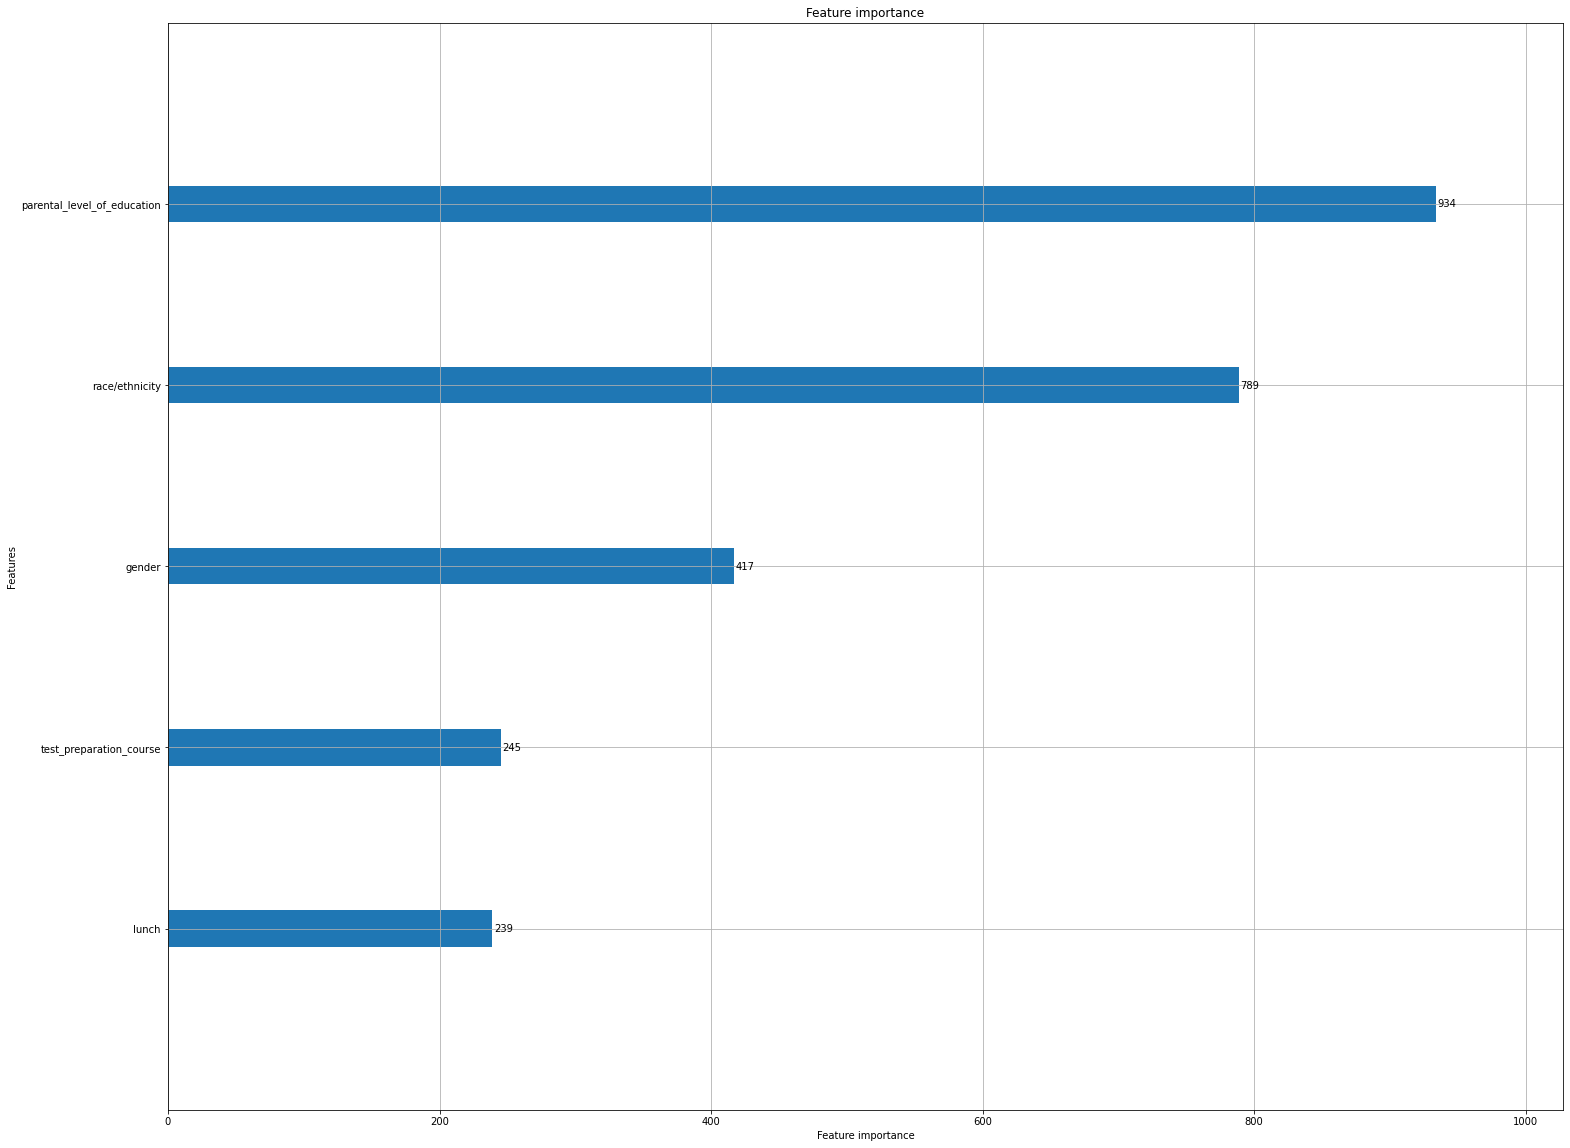

In [35]:
lgb.plot_importance(LGBMReg,figsize=(25,20))

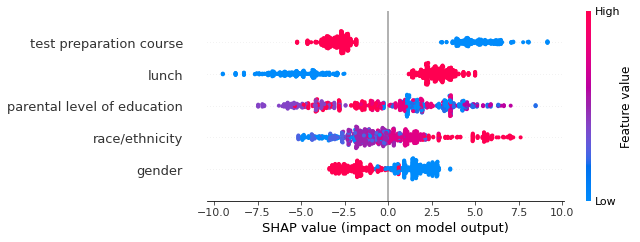

In [36]:
#LGBMReg.params['objective'] = 'regression'
shap_values = shap.TreeExplainer(LGBMReg).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## k Najbližih susjeda (kNN)

In [37]:
from sklearn import neighbors

rmse_val = [] #to store rmse values for different k
for K in range(150):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values

In [38]:
data2 = {"k": range(1,151),"RMSE": rmse_val}
final_rmse=pd.DataFrame(data2)
min_index = final_rmse.iloc[:,1].idxmin()

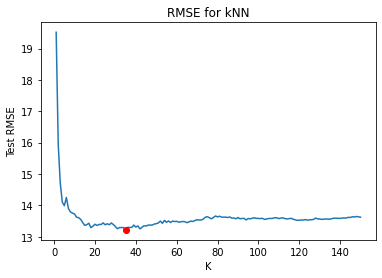

In [39]:
plt.plot(final_rmse.k, final_rmse.RMSE)
plt.plot(final_rmse.k[min_index],final_rmse.RMSE[min_index],'ro')
plt.title('RMSE for kNN')
plt.xlabel('K')
plt.ylabel('Test RMSE')
plt.show()

### Model s najmanjim RMSE

In [40]:
model = neighbors.KNeighborsRegressor(n_neighbors = final_rmse.k[min_index])

model.fit(X_train, y_train) 
pred=model.predict(X_test)

In [41]:
data.loc['kNN'] = evaluateRegressor(y_test, pred)

Test set evaluation:
MSE: 174.6476861678005
MAE: 10.994190476190479
RMSE: 13.215433635253914
R-squared: 0.1130425048290239 , from <0,1> 


## CATBoost

### Pretraživanje hiperparametra: $iterations$

In [42]:
from catboost import CatBoostRegressor

train_data = X_train
eval_data = X_test
train_labels = y_train


k=50

treeScoresTest1=np.zeros(k)
treeScoresTrain1=np.zeros(k)
treeScoresTest2=np.zeros(k)
treeScoresTrain2=np.zeros(k)
treeScoresTest3=np.zeros(k)
treeScoresTrain3=np.zeros(k)


for i in np.arange(1,k+1):
        # Initialize CatBoostRegressor
    model = CatBoostRegressor(iterations=i,
                              learning_rate=1,
                              depth=2)
    # Fit model
    model.fit(train_data, train_labels)
    
    
    treeScoresTrain1[i-1]=r2_score(y_train, model.predict(X_train))
    treeScoresTest1[i-1] =r2_score(y_test, model.predict(X_test))
    treeScoresTrain2[i-1]= max_error(y_train, model.predict(X_train))
    treeScoresTest2[i-1] = max_error(y_test, model.predict(X_test))
    treeScoresTrain3[i-1]= mean_squared_error (y_train, model.predict(X_train))
    treeScoresTest3[i-1] = mean_squared_error (y_test, model.predict(X_test))


0:	learn: 13.1417623	total: 161ms	remaining: 0us
0:	learn: 13.1417623	total: 562us	remaining: 562us
1:	learn: 12.8818820	total: 1.17ms	remaining: 0us
0:	learn: 13.1417623	total: 635us	remaining: 1.27ms
1:	learn: 12.8818820	total: 1.35ms	remaining: 675us
2:	learn: 12.6381100	total: 1.98ms	remaining: 0us
0:	learn: 13.1417623	total: 586us	remaining: 1.76ms
1:	learn: 12.8818820	total: 1.24ms	remaining: 1.24ms
2:	learn: 12.6381100	total: 1.88ms	remaining: 627us
3:	learn: 12.5622400	total: 2.51ms	remaining: 0us
0:	learn: 13.1417623	total: 556us	remaining: 2.23ms
1:	learn: 12.8818820	total: 1.52ms	remaining: 2.28ms
2:	learn: 12.6381100	total: 2.17ms	remaining: 1.45ms
3:	learn: 12.5622400	total: 2.73ms	remaining: 683us
4:	learn: 12.5222327	total: 3.25ms	remaining: 0us
0:	learn: 13.1417623	total: 690us	remaining: 3.45ms
1:	learn: 12.8818820	total: 1.42ms	remaining: 2.85ms
2:	learn: 12.6381100	total: 2.02ms	remaining: 2.02ms
3:	learn: 12.5622400	total: 2.64ms	remaining: 1.32ms
4:	learn: 12.52223

1:	learn: 12.8818820	total: 1.37ms	remaining: 12.3ms
2:	learn: 12.6381100	total: 1.89ms	remaining: 10.7ms
3:	learn: 12.5622400	total: 2.39ms	remaining: 9.55ms
4:	learn: 12.5222327	total: 3.02ms	remaining: 9.04ms
5:	learn: 12.4798095	total: 3.54ms	remaining: 8.27ms
6:	learn: 12.4662983	total: 4.02ms	remaining: 7.46ms
7:	learn: 12.4508972	total: 4.47ms	remaining: 6.71ms
8:	learn: 12.4274977	total: 4.93ms	remaining: 6.03ms
9:	learn: 12.3909840	total: 5.38ms	remaining: 5.38ms
10:	learn: 12.3682772	total: 5.84ms	remaining: 4.78ms
11:	learn: 12.3603241	total: 6.28ms	remaining: 4.18ms
12:	learn: 12.3538529	total: 6.73ms	remaining: 3.62ms
13:	learn: 12.3487709	total: 7.19ms	remaining: 3.08ms
14:	learn: 12.3370782	total: 7.78ms	remaining: 2.59ms
15:	learn: 12.3355957	total: 8.26ms	remaining: 2.07ms
16:	learn: 12.3327039	total: 8.74ms	remaining: 1.54ms
17:	learn: 12.3274308	total: 9.19ms	remaining: 1.02ms
18:	learn: 12.3102637	total: 9.68ms	remaining: 509us
19:	learn: 12.3008497	total: 10.2ms	re

7:	learn: 12.4508972	total: 4.25ms	remaining: 11.1ms
8:	learn: 12.4274977	total: 4.75ms	remaining: 10.6ms
9:	learn: 12.3909840	total: 5.29ms	remaining: 10.1ms
10:	learn: 12.3682772	total: 6.15ms	remaining: 10.1ms
11:	learn: 12.3603241	total: 7.02ms	remaining: 9.95ms
12:	learn: 12.3538529	total: 7.51ms	remaining: 9.25ms
13:	learn: 12.3487709	total: 7.99ms	remaining: 8.55ms
14:	learn: 12.3370782	total: 8.44ms	remaining: 7.88ms
15:	learn: 12.3355957	total: 8.9ms	remaining: 7.23ms
16:	learn: 12.3327039	total: 9.45ms	remaining: 6.67ms
17:	learn: 12.3274308	total: 10.1ms	remaining: 6.16ms
18:	learn: 12.3102637	total: 10.5ms	remaining: 5.55ms
19:	learn: 12.3008497	total: 11ms	remaining: 4.96ms
20:	learn: 12.2798869	total: 11.6ms	remaining: 4.42ms
21:	learn: 12.2784939	total: 12.1ms	remaining: 3.84ms
22:	learn: 12.2722930	total: 12.5ms	remaining: 3.26ms
23:	learn: 12.2689440	total: 13ms	remaining: 2.7ms
24:	learn: 12.2545392	total: 13.4ms	remaining: 2.15ms
25:	learn: 12.2456176	total: 13.9ms	r

0:	learn: 13.1417623	total: 632us	remaining: 21.5ms
1:	learn: 12.8818820	total: 1.23ms	remaining: 20.3ms
2:	learn: 12.6381100	total: 1.67ms	remaining: 17.8ms
3:	learn: 12.5622400	total: 2.09ms	remaining: 16.2ms
4:	learn: 12.5222327	total: 2.5ms	remaining: 15ms
5:	learn: 12.4798095	total: 2.99ms	remaining: 14.5ms
6:	learn: 12.4662983	total: 3.5ms	remaining: 14ms
7:	learn: 12.4508972	total: 4.04ms	remaining: 13.6ms
8:	learn: 12.4274977	total: 4.52ms	remaining: 13.1ms
9:	learn: 12.3909840	total: 4.98ms	remaining: 12.5ms
10:	learn: 12.3682772	total: 5.46ms	remaining: 11.9ms
11:	learn: 12.3603241	total: 6.04ms	remaining: 11.6ms
12:	learn: 12.3538529	total: 6.51ms	remaining: 11ms
13:	learn: 12.3487709	total: 6.96ms	remaining: 10.4ms
14:	learn: 12.3370782	total: 7.42ms	remaining: 9.89ms
15:	learn: 12.3355957	total: 7.87ms	remaining: 9.35ms
16:	learn: 12.3327039	total: 8.36ms	remaining: 8.86ms
17:	learn: 12.3274308	total: 8.82ms	remaining: 8.33ms
18:	learn: 12.3102637	total: 9.28ms	remaining: 

1:	learn: 12.8818820	total: 1.36ms	remaining: 25.9ms
2:	learn: 12.6381100	total: 1.87ms	remaining: 23.1ms
3:	learn: 12.5622400	total: 2.38ms	remaining: 21.5ms
4:	learn: 12.5222327	total: 3.11ms	remaining: 21.8ms
5:	learn: 12.4798095	total: 3.68ms	remaining: 20.9ms
6:	learn: 12.4662983	total: 4.17ms	remaining: 19.7ms
7:	learn: 12.4508972	total: 4.63ms	remaining: 18.5ms
8:	learn: 12.4274977	total: 5.09ms	remaining: 17.6ms
9:	learn: 12.3909840	total: 5.54ms	remaining: 16.6ms
10:	learn: 12.3682772	total: 5.98ms	remaining: 15.8ms
11:	learn: 12.3603241	total: 6.43ms	remaining: 15ms
12:	learn: 12.3538529	total: 6.89ms	remaining: 14.3ms
13:	learn: 12.3487709	total: 7.34ms	remaining: 13.6ms
14:	learn: 12.3370782	total: 7.79ms	remaining: 13ms
15:	learn: 12.3355957	total: 8.24ms	remaining: 12.4ms
16:	learn: 12.3327039	total: 8.7ms	remaining: 11.8ms
17:	learn: 12.3274308	total: 9.16ms	remaining: 11.2ms
18:	learn: 12.3102637	total: 9.63ms	remaining: 10.6ms
19:	learn: 12.3008497	total: 10.1ms	remain

0:	learn: 13.1417623	total: 607us	remaining: 26.7ms
1:	learn: 12.8818820	total: 1.26ms	remaining: 27.1ms
2:	learn: 12.6381100	total: 1.81ms	remaining: 25.4ms
3:	learn: 12.5622400	total: 2.31ms	remaining: 23.7ms
4:	learn: 12.5222327	total: 2.81ms	remaining: 22.5ms
5:	learn: 12.4798095	total: 3.28ms	remaining: 21.3ms
6:	learn: 12.4662983	total: 3.89ms	remaining: 21.1ms
7:	learn: 12.4508972	total: 4.64ms	remaining: 21.5ms
8:	learn: 12.4274977	total: 5.33ms	remaining: 21.3ms
9:	learn: 12.3909840	total: 5.81ms	remaining: 20.3ms
10:	learn: 12.3682772	total: 6.26ms	remaining: 19.3ms
11:	learn: 12.3603241	total: 6.78ms	remaining: 18.7ms
12:	learn: 12.3538529	total: 7.27ms	remaining: 17.9ms
13:	learn: 12.3487709	total: 7.71ms	remaining: 17.1ms
14:	learn: 12.3370782	total: 8.24ms	remaining: 16.5ms
15:	learn: 12.3355957	total: 8.73ms	remaining: 15.8ms
16:	learn: 12.3327039	total: 9.25ms	remaining: 15.2ms
17:	learn: 12.3274308	total: 9.73ms	remaining: 14.6ms
18:	learn: 12.3102637	total: 10.2ms	rem

10:	learn: 12.3682772	total: 7.69ms	remaining: 26.6ms
11:	learn: 12.3603241	total: 8.3ms	remaining: 25.6ms
12:	learn: 12.3538529	total: 8.91ms	remaining: 24.7ms
13:	learn: 12.3487709	total: 9.43ms	remaining: 23.6ms
14:	learn: 12.3370782	total: 9.98ms	remaining: 22.6ms
15:	learn: 12.3355957	total: 10.5ms	remaining: 21.6ms
16:	learn: 12.3327039	total: 10.9ms	remaining: 20.5ms
17:	learn: 12.3274308	total: 11.4ms	remaining: 19.6ms
18:	learn: 12.3102637	total: 12ms	remaining: 18.9ms
19:	learn: 12.3008497	total: 12.5ms	remaining: 18.1ms
20:	learn: 12.2798869	total: 13ms	remaining: 17.3ms
21:	learn: 12.2784939	total: 13.5ms	remaining: 16.5ms
22:	learn: 12.2722930	total: 13.9ms	remaining: 15.8ms
23:	learn: 12.2689440	total: 14.4ms	remaining: 15ms
24:	learn: 12.2545392	total: 14.8ms	remaining: 14.3ms
25:	learn: 12.2456176	total: 15.3ms	remaining: 13.6ms
26:	learn: 12.2446105	total: 15.8ms	remaining: 12.9ms
27:	learn: 12.2315598	total: 16.3ms	remaining: 12.2ms
28:	learn: 12.2281647	total: 16.8ms

Max test: 0.217
Max train:0.277
Max test index:3


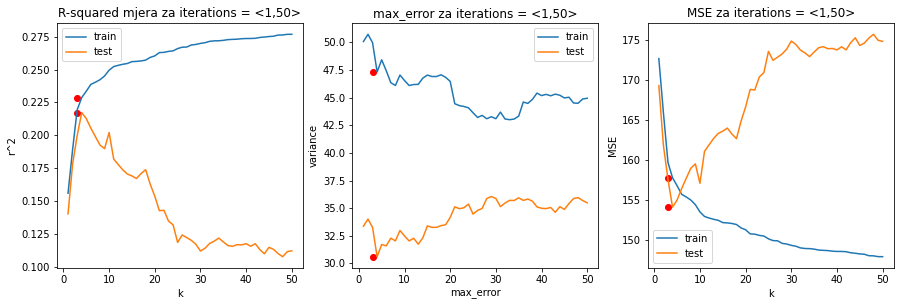

In [43]:
maximumTE = np.max(treeScoresTest1)
minimumTR = np.max(treeScoresTrain1)

print("Max test: " + str(round(maximumTE,3)) )
print("Max train:" + str(round(minimumTR,3)) )

index_of_maximum = np.where(treeScoresTest1 == maximumTE)[0][0]
print("Max test index:" + str(index_of_maximum) )


fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))


ax[0].plot(index_of_maximum,treeScoresTrain1[index_of_maximum],'ro')
ax[0].plot(index_of_maximum,treeScoresTest1[index_of_maximum],'ro')

ax[0].plot(np.arange(1,k+1),treeScoresTrain1,label='train')
ax[0].plot(np.arange(1,k+1),treeScoresTest1,label='test')
ax[0].set(xlabel='k', ylabel='r^2')
ax[0].title.set_text(f"R-squared mjera za iterations = <1,{k}>")
ax[0].legend()

ax[1].plot(index_of_maximum,treeScoresTrain2[index_of_maximum],'ro')
ax[1].plot(index_of_maximum,treeScoresTest2[index_of_maximum],'ro')

ax[1].plot(np.arange(1,k+1),treeScoresTrain2,label='train')
ax[1].plot(np.arange(1,k+1),treeScoresTest2,label='test')
ax[1].set(xlabel='max_error', ylabel='variance')
ax[1].title.set_text(f"max_error za iterations = <1,{k}>")
ax[1].legend()

ax[2].plot(index_of_maximum,treeScoresTrain3[index_of_maximum],'ro')
ax[2].plot(index_of_maximum,treeScoresTest3[index_of_maximum],'ro')

ax[2].plot(np.arange(1,k+1),treeScoresTrain3,label='train')
ax[2].plot(np.arange(1,k+1),treeScoresTest3,label='test')
ax[2].set(xlabel='k', ylabel='MSE')
ax[2].title.set_text(f"MSE za iterations = <1,{k}>")
ax[2].legend()


plt.show()

### Najbolji hiperparametar $iterations$ nađen

In [44]:

model = CatBoostRegressor(iterations=index_of_maximum,
                          learning_rate=1,
                          depth=2)

model.fit(train_data, train_labels)

pred = model.predict(eval_data)

0:	learn: 13.1417623	total: 569us	remaining: 1.14ms
1:	learn: 12.8818820	total: 1.41ms	remaining: 705us
2:	learn: 12.6381100	total: 1.94ms	remaining: 0us


In [45]:
print("\nScores:")
data.loc['CATBoost'] = evaluateRegressor(y_test, pred)


Scores:
Test set evaluation:
MSE: 157.60841464417547
MAE: 10.293333847255294
RMSE: 12.554218997778216
R-squared: 0.1995773448933349 , from <0,1> 


## ANN

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


model = Sequential()
model.add(Dense(100, input_dim=X_train.columns.value_counts().sum(), activation="softmax"))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, kernel_initializer="normal"))
model.compile(loss="mean_squared_error", optimizer = "adam", metrics = ["mse"])

model.fit(X_train, y_train, epochs=10)

Epoch 1/10
25/25 [==============================] - 1s 2ms/step - loss: 4795.3774 - mse: 4795.3774
Epoch 2/10
25/25 [==============================] - 0s 2ms/step - loss: 4757.2598 - mse: 4757.2598
Epoch 3/10
25/25 [==============================] - 0s 2ms/step - loss: 4686.4595 - mse: 4686.4595
Epoch 4/10
25/25 [==============================] - 0s 2ms/step - loss: 4572.3433 - mse: 4572.3433
Epoch 5/10
25/25 [==============================] - 0s 2ms/step - loss: 4409.5908 - mse: 4409.5908
Epoch 6/10
25/25 [==============================] - 0s 2ms/step - loss: 4194.1680 - mse: 4194.1680
Epoch 7/10
25/25 [==============================] - 0s 2ms/step - loss: 3928.5305 - mse: 3928.5305
Epoch 8/10
25/25 [==============================] - 0s 3ms/step - loss: 3617.6477 - mse: 3617.6477
Epoch 9/10
25/25 [==============================] - 0s 2ms/step - loss: 3271.3303 - mse: 3271.3303
Epoch 10/10
25/25 [==============================] - 0s 2ms/step - loss: 2897.2983 - mse: 2897.2983


In [47]:
from tensorflow.keras.models import Model, load_model
#model.save('cnn_model.h5')
#model = load_model('cnn_model.h5')

predicted_y_test = model.predict(X_test)
predicted_y_test = pd.Series([i[0] for i in predicted_y_test])

In [48]:
data.loc['ANN'] = evaluateRegressor(y_test, predicted_y_test)

Test set evaluation:
MSE: 2657.9214827926753
MAE: 49.60735871950785
RMSE: 51.5550335349777
R-squared: -12.498394582072395 , from <0,1> 


## Slučajne šume

### Pretraživanje hiperparametra: $n\_estimators$

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,max_error

In [50]:
k=50

treeScoresTest1=np.zeros(k)
treeScoresTrain1=np.zeros(k)
treeScoresTest2=np.zeros(k)
treeScoresTrain2=np.zeros(k)
treeScoresTest3=np.zeros(k)
treeScoresTrain3=np.zeros(k)



#X_train, X_test, y_train, y_test 


for k in np.arange(1,k+1):
    rf = RandomForestRegressor(n_estimators=k)
    rf.fit(X_train,y_train)
    treeScoresTrain1[k-1]=r2_score(y_train, rf.predict(X_train))
    treeScoresTest1[k-1] =r2_score(y_test, rf.predict(X_test))
    treeScoresTrain2[k-1]= max_error(y_train, rf.predict(X_train))
    treeScoresTest2[k-1] = max_error(y_test, rf.predict(X_test))
    treeScoresTrain3[k-1]= mean_squared_error (y_train, rf.predict(X_train))
    treeScoresTest3[k-1] = mean_squared_error (y_test, rf.predict(X_test))

Max test: -0.092
Max train:0.405
Max test index:9


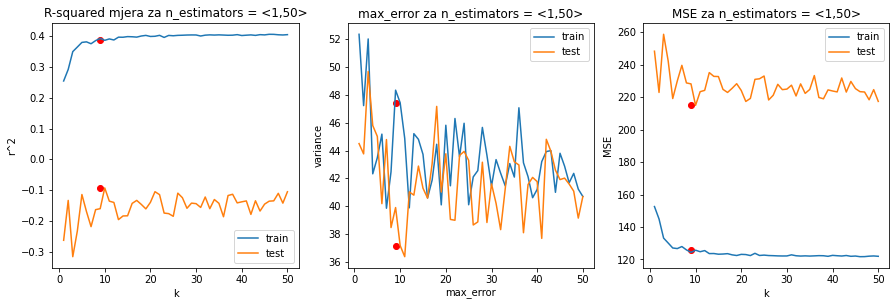

In [51]:

maximumTE = np.max(treeScoresTest1)
minimumTR = np.max(treeScoresTrain1)

print("Max test: " + str(round(maximumTE,3)) )
print("Max train:" + str(round(minimumTR,3)) )

index_of_maximum = np.where(treeScoresTest1 == maximumTE)[0][0]
print("Max test index:" + str(index_of_maximum) )


fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))


ax[0].plot(index_of_maximum,treeScoresTrain1[index_of_maximum],'ro')
ax[0].plot(index_of_maximum,treeScoresTest1[index_of_maximum],'ro')
ax[0].plot(np.arange(1,k+1),treeScoresTrain1,label='train')
ax[0].plot(np.arange(1,k+1),treeScoresTest1,label='test')
ax[0].set(xlabel='k', ylabel='r^2')
ax[0].title.set_text(f"R-squared mjera za n_estimators = <1,{k}>")
ax[0].legend()

ax[1].plot(index_of_maximum,treeScoresTrain2[index_of_maximum],'ro')
ax[1].plot(index_of_maximum,treeScoresTest2[index_of_maximum],'ro')

ax[1].plot(np.arange(1,k+1),treeScoresTrain2,label='train')
ax[1].plot(np.arange(1,k+1),treeScoresTest2,label='test')
ax[1].set(xlabel='max_error', ylabel='variance')
ax[1].title.set_text(f"max_error za n_estimators = <1,{k}>")
ax[1].legend()

ax[2].plot(index_of_maximum,treeScoresTrain3[index_of_maximum],'ro')
ax[2].plot(index_of_maximum,treeScoresTest3[index_of_maximum],'ro')

ax[2].plot(np.arange(1,k+1),treeScoresTrain3,label='train')
ax[2].plot(np.arange(1,k+1),treeScoresTest3,label='test')
ax[2].set(xlabel='k', ylabel='MSE')
ax[2].title.set_text(f"MSE za n_estimators = <1,{k}>")
ax[2].legend()


plt.show()



### Našli smo $\text{n_estimators}$ koji daje najmanju grešku nad $test$ skupom:

In [52]:
rf = RandomForestRegressor(n_estimators=index_of_maximum)
rf.fit(X_train,y_train)
# Predictions
predictions = rf.predict(X_test)

In [53]:

data.loc['Random forest'] =evaluateRegressor(y_test, predictions)

Test set evaluation:
MSE: 239.20247701622856
MAE: 12.43311544827742
RMSE: 15.466172022068957
R-squared: -0.21480240882872392 , from <0,1> 


### Koji atributi doprinose najviše modelu slučajnih šuma

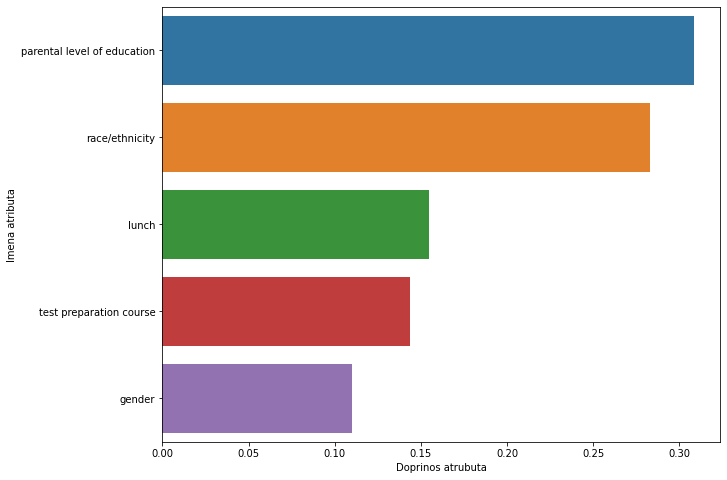

In [54]:
feature_importance = np.array(rf.feature_importances_)
feature_names = np.array(X_train.columns)
data2={'feature_names':feature_names,'feature_importance':feature_importance}
df_plt = pd.DataFrame(data2)
df_plt.sort_values(by=['feature_importance'], ascending=False,inplace=True)
plt.figure(figsize=(10,8))
sns.barplot(x=df_plt['feature_importance'], y=df_plt['feature_names'])
plt.xlabel('Doprinos atrubuta')
plt.ylabel('Imena atributa')
plt.show()

### Prikaz razlike predikcije i oznaka, dobili smo normalnu razdiobu pa možemo pretpostaviti da je model relativno dobar

<AxesSubplot:xlabel='AVERAGE', ylabel='Density'>

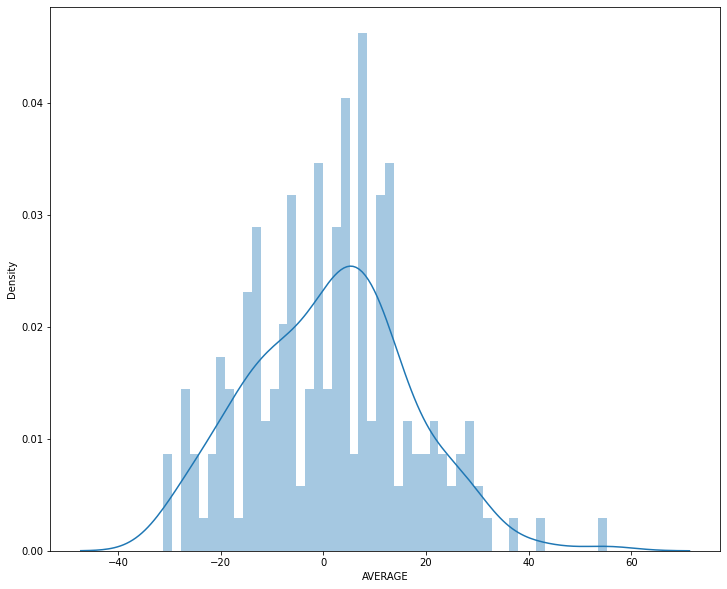

In [55]:
plt.figure(figsize=(12,10))
sns.distplot((y_test-predictions), bins = 50)

## SVM

In [56]:
from sklearn.svm import SVR
def SV_reg(kernel,X_train, y_train):
    model=SVR(kernel)
    model.fit(X_train, y_train)
    return model


SVM_model= SV_reg("linear",X_train, y_train)
pred_linear = SVM_model.predict(X_test)
linear_rmse = np.sqrt(mean_squared_error(y_test,pred_linear))

SVM_model= SV_reg("poly",X_train, y_train)
pred_poly = SVM_model.predict(X_test)
poly_rmse = np.sqrt(mean_squared_error(y_test,pred_poly))

SVM_model= SV_reg("sigmoid",X_train, y_train)
pred_sigmoid = SVM_model.predict(X_test)
sigmoid_rmse = np.sqrt(mean_squared_error(y_test,pred_sigmoid))

SVM_model= SV_reg("rbf",X_train, y_train)
pred_rbf = SVM_model.predict(X_test)
rbf_rmse = np.sqrt(mean_squared_error(y_test,pred_rbf))



data2 = {"kernel":pd.Series(["linear","polynomial","sigmoid","rbf"]),
            "Test RMSE":pd.Series([linear_rmse,poly_rmse,sigmoid_rmse,rbf_rmse])}
table_rmse=pd.DataFrame(data2)
table_rmse

,kernel,Test RMSE
0,linear,12.612705
1,polynomial,13.331107
2,sigmoid,21.841087
3,rbf,13.281722


### Umjesto ručnog pretraživanja hiperparametara $C$ i $\text{gamma}\ \gamma$ , koristimo funkciju $GridSearchCV$ za traženje hp. za 3 jezgrene fje. s najmanjom greškom

In [57]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

K = 15
#parameters = [{'kernel': ['linear','polynomial','rbf'], 'gamma': [2e-2, 2e-1, 1,  8],'C': [2e-3,2e-2, 2, 4]}]
#scorer = make_scorer(mean_squared_error, greater_is_better=False)
#svr_gs = GridSearchCV(SVR(epsilon = 0.01), parameters, cv = K, scoring=scorer)

#svr_gs.fit(X_train, y_train)
#print(svr_gs.best_params_)

 Naći čemo npr. {'C': 2, 'gamma': 0.002, 'kernel': 'linear'}

In [58]:
regressor = SVR(C=2,gamma=0.002,kernel='linear')
#regressor = SVR(**svr_gs.best_params_)
regressor.fit(X_train,y_train)
pred=regressor.predict(X_test)

In [59]:
data.loc['SVR_best'] = evaluateRegressor(y_test,pred)

Test set evaluation:
MSE: 158.8159506608259
MAE: 10.260601296880775
RMSE: 12.60222006873495
R-squared: 0.19344480947784726 , from <0,1> 


# DoWhy kauzalna analiza

## Priprema podataka

In [61]:
data_X_labeled= encode_data(df,enc_type="LABEL")
data_y_labeled= pd.cut(Y,
       5, labels=[1,2,3,4,5])

spojeno = pd.concat([data_X_labeled, data_y_labeled], axis=1)

In [62]:
spojeno.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'AVERAGE'],
      dtype='object')

## Analiza

In [63]:
import dowhy
from dowhy import CausalModel

In [64]:
model=CausalModel(
        data = spojeno,
        treatment='lunch',
        outcome='AVERAGE',
        common_causes=['gender','test preparation course', 'parental level of education','race/ethnicity']
        )

In [65]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(AVERAGE|parental level of education,gender,test preparati
d[lunch]                                                                      

                          
on course,race/ethnicity))
                          
Estimand assumption 1, Unconfoundedness: If U→{lunch} and U→AVERAGE then P(AVERAGE|lunch,parental level of education,gender,test preparation course,race/ethnicity,U) = P(AVERAGE|lunch,parental level of education,gender,test preparation course,race/ethnicity)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [66]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)
print(estimate)
print("Causal Estimate is " + str(estimate.value))
data_1 = spojeno[spojeno["lunch"]==1]
data_0 = spojeno[spojeno["race/ethnicity"]==0]
print("ATE", np.mean(data_1["AVERAGE"].cat.codes)- np.mean(data_0["AVERAGE"].cat.codes))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(AVERAGE|parental level of education,gender,test preparati
d[lunch]                                                                      

                          
on course,race/ethnicity))
                          
Estimand assumption 1, Unconfoundedness: If U→{lunch} and U→AVERAGE then P(AVERAGE|lunch,parental level of education,gender,test preparation course,race/ethnicity,U) = P(AVERAGE|lunch,parental level of education,gender,test preparation course,race/ethnicity)

## Realized estimand
b: AVERAGE~lunch+parental level of education+gender+test preparation course+race/ethnicity
Target units: ate

## Estimate
Mean value: 0.48169465924595345
p-value: [5.06520702e-22]

Causal Estimate is 0.48169465924595345
ATE 0.4540545248671717


refute steps

    The refute steps tests the strength and validity of the causal effect found by the estimate step. There are a variety of different refutation methods, eg. Subset Validation (using only a subset of the data to estimate the causal effect) or Placebo Treatment (turning the treatment into a placebo and seeing its effect on the outcome (the placebo treatment refutation expects the causal effect to go down)) In this case, we’ll be adding an irrelevant common cause to test the strength of the causal relationship between the treatment and outcome. This is useful because it changes the causal model but not the relationship between y_factual and treatment.

In [67]:
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:0.48169465924595345
New effect:0.4819326290482153



Adding a random common cause didn’t have much of an effect on the causal effect (as expected) and so we can be more assured of the strength of the causal relationship.

# Rezultati & zaključak

Usporedimo rezultate koje smo dobili:

In [68]:
data

,MSE,MAE,RMSE,R^2
linearna,155.777511,10.093111,12.481086,0.208876
Multi-Lasso,199.829786,11.198105,14.131149,0.187380
LightGBM,185.744905,11.115567,13.628826,0.056685
kNN,174.647686,10.994190,13.215434,0.113043
CATBoost,157.608415,10.293334,12.554219,0.199577
ANN,2657.921483,49.607359,51.555034,-12.498395
Random forest,239.202477,12.433115,15.466172,-0.214802
SVR_best,158.815951,10.260601,12.602220,0.193445


    U svim modelima predviđeni rezultati imaju dosta veliku grešku. To je možda zato što je skup malen te su atributi kategoričke varijable, te zato što dane varijable jednostavno nemaju nikakvu uzročno posljedičnu vezu oznakama ,tj. rezultatima ispita. Možda bi nam više pomogle varijable koje se odnose više na samog učenika, koliko je sati učio tjedno ili koliko je redovan na nastavi itd.

### 1) Linearna regresija

Objasnjena varijanca = 0.31

R2 = 0.30

MSE = 146.31


### 2) Lasso regresija

math score       13.860696

reading score    12.818428

writing score    12.563250

dtype: float64

Scores:

MSE: 171.4220845033959

MAE: 10.427402013978332

RMSE: 13.080791496714767

R-squared: 0.256177633475969 , from <0,1> 

### 3) Ridge regresija

Objasnjena varijanca = 0.31

R2 = 0.30

MSE = 147.49

### 4) LightGBM

#### Training set: 

MSE: 137.64572706425244

MAE: 9.370538765975732

RMSE: 11.732251576924714

R-squared: 0.3197861707087939 , from <0,1> 

#### Test set:

MSE: 157.60183185692952

MAE: 10.030038841736843

RMSE: 12.55395682073702

R-squared: 0.23452270735099223 , from <0,1> 

### 5) CATBoost

residual: 12.201670629835073

Scores:

#### Training set:

MSE: 151.84207703449752

MAE: 9.851195477728904

RMSE: 12.322421719552432

R-squared: 0.24963104289497606 , from <0,1> 

#### Test set:

MSE: 148.8807661589799

MAE: 9.798469509213694

RMSE: 12.201670629835077

R-squared: 0.27688121093450935 , from <0,1> 

### 6) ANN

residual: 55.85805384144501

#### Test set

MSE: 3049.504034898524

MAE: 53.3235610850652

RMSE: 55.22231464633227

R-squared: -13.811541623928848 , from <0,1> 

### 7) Slučajne šume

residual: 13.338086174261672

#### Test set

MSE: 177.90454279203027

MAE: 10.439747508369027

RMSE: 13.338086174261669

R-squared: 0.1359117710634964 , from <0,1> 

### 8) SVM

#### Training Set

MSE: 171.80606176871777

MAE: 10.350196062160261

RMSE: 13.107481137454204

R-squared: 0.15097357786784782 , from <0,1> 

#### Test Set

MSE: 167.5987303747367

MAE: 10.30968181798135

RMSE: 12.945992830785004

R-squared: 0.18596744170379642 , from <0,1> 